In [4]:
# Install required libraries with explanations:
!pip install tensorflow numpy matplotlib opencv-python scikit-learn
# tensorflow: Core library to define, train, and evaluate neural networks
# numpy: package for numerical computations like array and matrices
# matplotlib: Plotting library for visualizing data like loss plots
# opencv-python: Computer vision tools for image processing (image augmenting)
# scikit-learn: Machine learning utilities (e.g., metrics like classification_report, data preprocessing)

#In Code : TensorFlow : Building/training the CNN (model.fit).
#NumPy : Handling arrays in data preprocessing.
#Matplotlib : Plotting the confusion matrix.
#OpenCV : Loading or preprocessing image data.
#Scikit-learn : Generating the classification report and confusion matrix.


In [5]:
#Importing Core libraries
import os as os #For interacting with the operating system
import numpy as np #For numerical computations
import tensorflow as tf # Core library for building and training neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data augmentation and image preprocessing
from tensorflow.keras.models import Sequential # Linear stack of neural network layers
from tensorflow.keras.layers import (  # Core neural network layers
    Conv2D,  # 2D convolutional layer (spatial feature extraction)
    MaxPooling2D,  # 2D pooling layer (downsamples spatial dimensions)
    Flatten,  # Flattens input for dense layers
    Dense,  # Fully connected (dense) layer
    Dropout )  # Regularization layer to prevent overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (  # Evaluation metrics for classification tasks
    confusion_matrix,  # Computes confusion matrix for error analysis
    classification_report  # Generates precision, recall, F1-score reports
)
import matplotlib.pyplot as plt  # Primary plotting library (loss curves, metrics)
import seaborn as sns  # Advanced statistical visualization (confusion matrix heatmap)
from tensorflow.keras.applications import ResNet50  # Import ResNet50 in case of using a secondary model for comparison


In [6]:

dataset_dir = r"C:\Users\sache\OneDrive\Desktop\Classes\dataset\data"  # Full path with "r" to avoid escape issues
train_dir = os.path.join(dataset_dir, "Train") #Path to training data folder
seed_value = 42 #random seed

img_height, img_width = 128, 128  # Resize images to 128x128
batch_size = 32 # Number of images processed per batch (balances memory usage and training speed)
train_datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2],  # Adjust brightness
    rescale=1.0/255,  # Normalize pixel values to [0,1]
    rotation_range=10, #Rotates the image by 20 degree
    width_shift_range=0.2, #shifts image width by 0.2
    height_shift_range=0.2, #shifts height by 0.2
    shear_range=0.1, #
    zoom_range=0.2, #zooms image by 0.2
    horizontal_flip=True, #flips image horizontally
    fill_mode="nearest" #after all the transformations, the empty pixels will be filled by nearest pixel
)
# This is necessary to prevent from overfitting so that we can train our images from different aspects

In [7]:
#Image Preprocessing 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the data generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    validation_split=0.1# Reserve 10% of the data for testing
)

# Flow training data from the directory
train_data = datagen.flow_from_directory(
    train_dir,  # Path to the main dataset folder
    target_size=(img_height, img_width),  # Resize images to this size
    batch_size=batch_size,  #Process 32 images per batch
    class_mode="categorical",  # Use "categorical" for multi-class classification
    subset="training"  # Specify this is the training subset (90% of the data)
    
)

# Flow testing data from the same directory
test_data = datagen.flow_from_directory(
    train_dir,  # Same path as above
    target_size=(img_height, img_width),  # Resize images to this size
    batch_size=batch_size, #same as above
    class_mode="categorical",  # Use "categorical" for multi-class classification
    subset="validation"  # Treat the "validation" subset as the test set (10% of the data)
)

# Dsiplay class labels for and splitted images
class_labels = list(train_data.class_indices.keys())
print("Class Labels:", class_labels)

Found 345 images belonging to 14 classes.
Found 31 images belonging to 14 classes.
Class Labels: ['Dakshinkali Temple', 'Kathmandu Durbar Square', 'Kopan Monastery', 'Lumbini- The birthplace of Gautam Buddha', 'Manakamana Temple', 'Sagarmatha National Park', 'Shashwat Dham', 'Shree Muktinath Temple', 'boudhanath_stupa_kathmandu', 'changu_narayan_temple', 'durbar_square_bhaktapur', 'hanuman_dhoka', 'kailashnath_mahadev_statue', 'pashupatinath_temple']


Random Samples from Training Data:


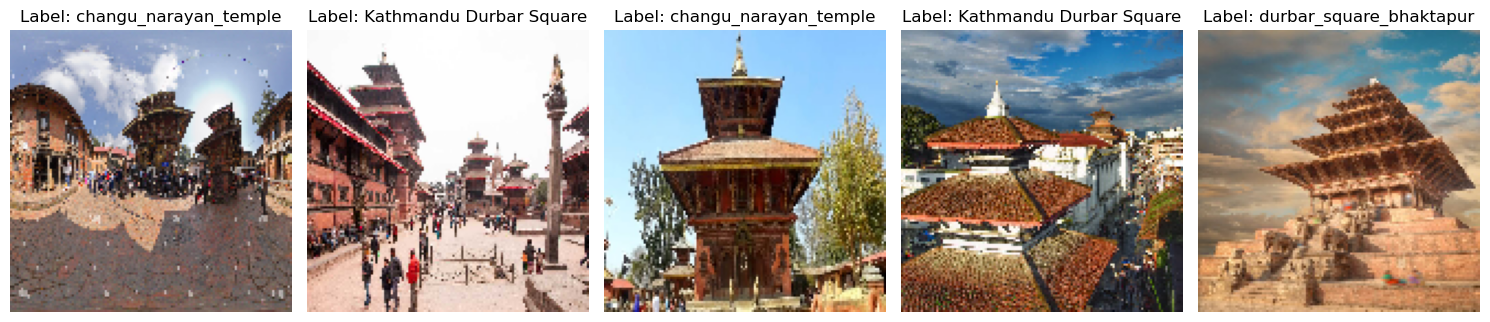

In [8]:
def show_random_samples(data_generator, class_labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Get a random batch of images
        images, labels = next(data_generator)
        image = images[0]  # Take the first image from the batch
        label_index = np.argmax(labels[0])  # Get the true label index
        label = class_labels[label_index]  # Map index to class label
        
        # Display the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display random samples
print("Random Samples from Training Data:")
show_random_samples(train_data, class_labels)

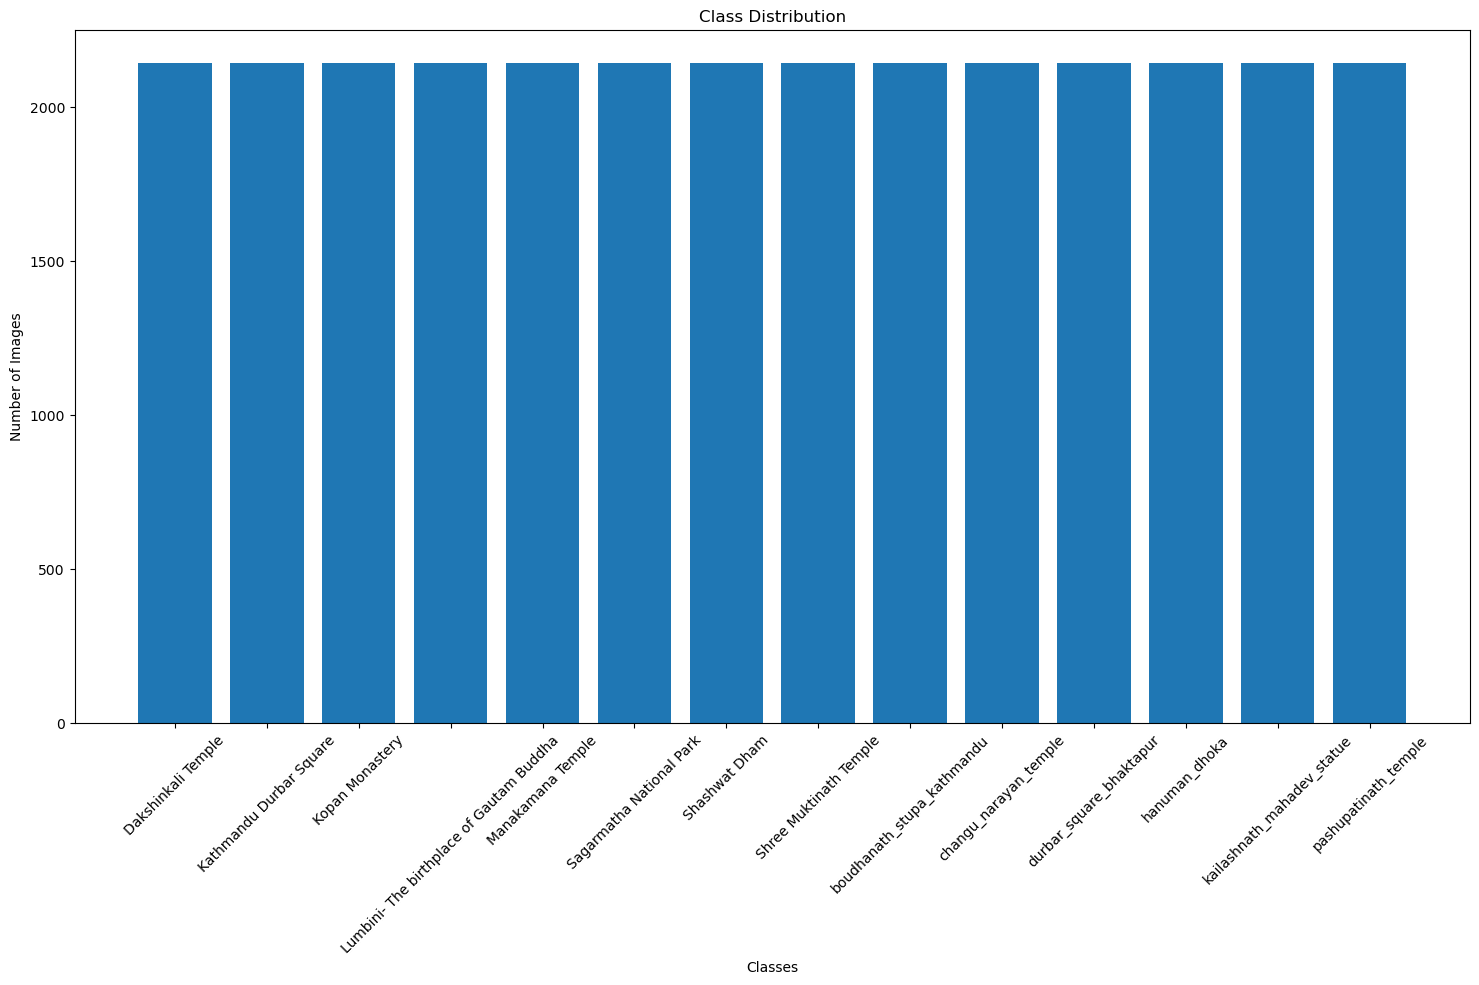

In [9]:
import matplotlib.pyplot as plt

# Count the number of images per class
class_counts = train_data.classes.sum(axis=0)
plt.figure(figsize=(18, 9))
plt.bar(class_labels, class_counts)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Add these imports at the beginning of your code
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input

def create_cnn_model(input_shape, num_classes):  # Fixed function definition
    model = Sequential([ #Sequential API allows us to build our CNN layers one by one, how we see fit 
         Input(shape=input_shape),
        #activation relu helps learn complex patterns
        #first convolutional block
        Conv2D(32, (3, 3), activation='relu'), #Applies 32 filters of size 3x3 to extract features from the input image.
        BatchNormalization(),  # Normalizes activations to stabilize training and prevent internal covariate shift.
        MaxPooling2D((2, 2)), #Downsamples feature maps by taking the maximum value from each 2×2 window.
        
        #second convolutional block
        Conv2D(64, (3, 3), activation='relu'),#Increases the number of filters to 64 for capturing more complex patterns
        BatchNormalization(),  #Stabalize training
        MaxPooling2D((2, 2)), 
        
        #third convolutional block
        Conv2D(128, (3, 3), activation='relu'), #128 filters for deepening feature extraction.
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        # fully connected layers
        Flatten(), # Flattens 2D feature maps to 1D vector
        Dense(128, activation='relu'),  # 128-node dense layer for high-level features
        Dropout(0.5), # Randomly drops 40% of neurons to prevent overfitting
        Dense(num_classes, activation='softmax')
    ])
    return model

# Example input shape and number of classes
input_shape = (128, 128, 3)  # Adjust based on your dataset
num_classes = 14  #number of classes in my dataset
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', #For Adaptive learning rate optimization
              loss='categorical_crossentropy', #We use crossentropy as we have multiple classes to identify
              metrics=['accuracy']) #For measuring our accuracy through metrices

# Print model summary
model.summary() #A detailed summary for our architecture.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,342 (12.62 MB)

 Trainable params: 3,306,894 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Training the model
# Suppress specific warnings related to TensorFlow/Keras dataset adapters
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

# Train the model without early stopping as we don't have the overfitting problem 
history = model.fit(
    train_data, #passing the train data
    epochs=25,   #Training for 25 complete passes over the dataset
    validation_data=test_data, #Performance evaluation on the test set after each epoch
)

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1093 - loss: 8.6248 - val_accuracy: 0.2581 - val_loss: 2.5946
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2346 - loss: 2.9143 - val_accuracy: 0.1290 - val_loss: 3.8101
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2520 - loss: 2.3080 - val_accuracy: 0.0968 - val_loss: 9.2473
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3388 - loss: 2.0246 - val_accuracy: 0.0968 - val_loss: 15.5497
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3381 - loss: 2.0299 - val_accuracy: 0.0968 - val_loss: 18.0626
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3881 - loss: 1.8573 - val_accuracy: 0.0968 - val_loss: 21.6176
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4659 - loss: 1.8397 - val_accuracy: 0.0968 - val_loss: 27.7776
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4090 - loss: 1.8404 - val_accuracy: 0.0968 - val_l

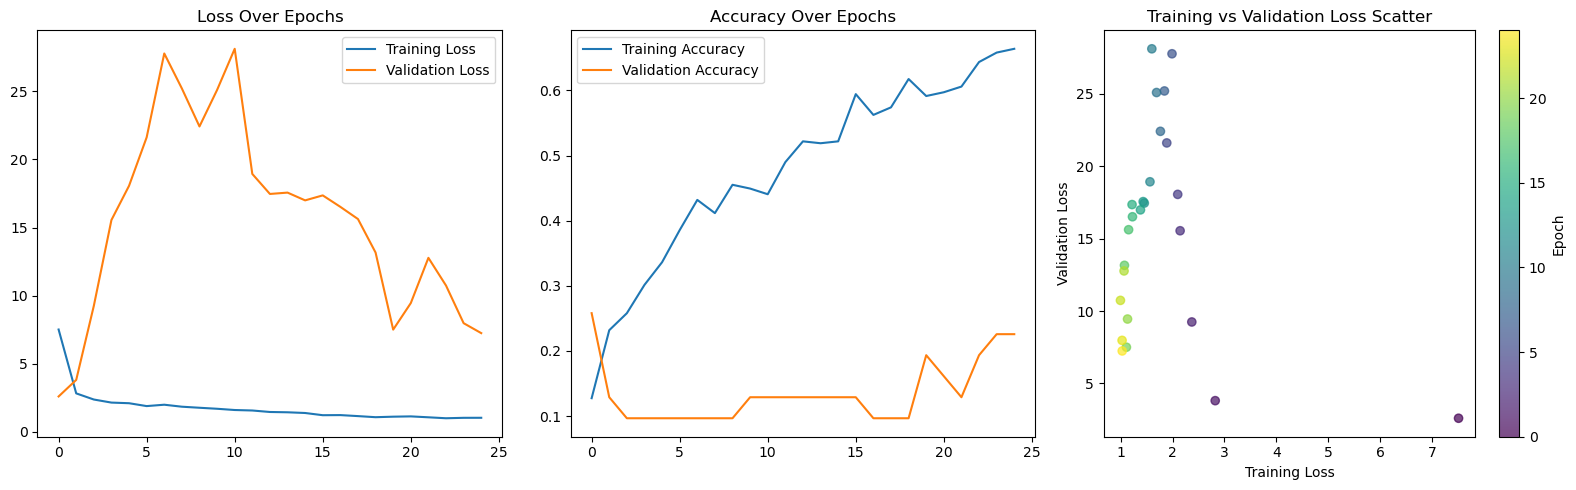

In [12]:
def plot_metrics(history): #defines a new function named `plot_metrics` that takes one parameter `history`, which contains our training metrics
    plt.figure(figsize=(16, 5))  #our figure size, length and width
    
       # 1. Loss plot (line plot)
    plt.subplot(1, 3, 1)  # Creates a subplot (1 row, 3 columns, first plot)
    plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
    plt.title('Loss Over Epochs')  # Add a title
    plt.legend()  # Show the legend for labels

    
       # 2. Accuracy plot (line plot)
    plt.subplot(1, 3, 2)  # Creates the second subplot (1 row, 3 columns, second plot)
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Accuracy Over Epochs')  # Add title
    plt.legend()  # Show legend

    
       # 3. Scatter plot (training vs validation loss)
    plt.subplot(1, 3, 3)  # Third subplot (1 row, 3 columns, third plot)
    plt.scatter(history.history['loss'], history.history['val_loss'], 
                c=range(len(history.history['loss'])), cmap='viridis', alpha=0.7)
    plt.xlabel('Training Loss')  # Label for x-axis
    plt.ylabel('Validation Loss')  # Label for y-axis
    plt.title('Training vs Validation Loss Scatter')  # Add title
    plt.colorbar(label='Epoch')  # Add color bar showing epoch progression

    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Displaying the plots

# Call the plotting function
plot_metrics(history)

In [13]:
import numpy as np #numerical operations 
from tensorflow.keras.preprocessing import image #loading our images after training
import matplotlib.pyplot as plt #For further visualization

def predict_landmark(image_path, model, class_labels, img_height=128, img_width=128):
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_height, img_width)) 
    img_array = image.img_to_array(img)  # Convert image to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]

    # Make prediction
    predictions = model.predict(img_array)  # Get probability distribution
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get class with highest probability

    # Validate class index AFTER defining it
    if predicted_class_index >= len(class_labels):
        return "Unknown Landmark"

    predicted_label = class_labels[predicted_class_index]  # Map index to class label
    return predicted_label  # Return prediction"

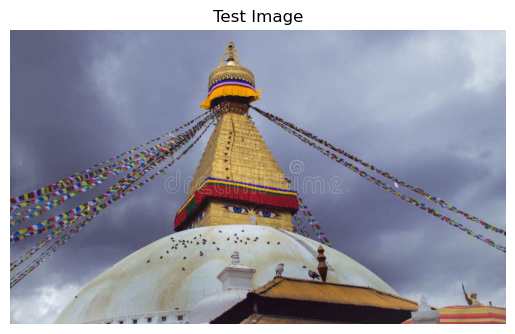

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Predicted Landmark: durbar_square_bhaktapur
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2258 - loss: 7.2448
Test Accuracy: 0.23
Test Loss: 7.24
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


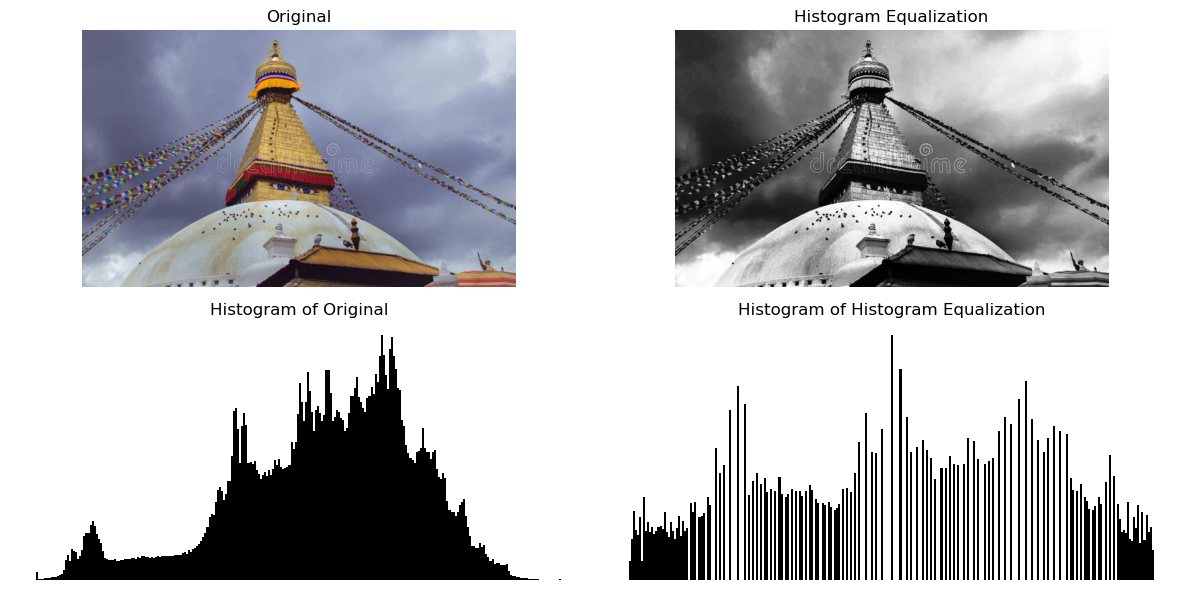

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Test with a sample image
from matplotlib import pyplot as plt
#Use "test_image_path = random.choice(test_data.filepaths)"  for testing with random image.
test_image_path = r"C:\Users\sache\OneDrive/Desktop/Classes/dataset/data/Test/Images/boudhanath_stupa_kathmandu/Image_12.jpg"# Replace with your 
#test image path

# Display the test image using Matplotlib
img = image.load_img(test_image_path)  # Loading image from the provided path
plt.imshow(img)  # Display the image
plt.title("Test Image")  # Setting our title for visualization
plt.axis('off')  # Hide axis to focus on the image
plt.show()  # Render the image

# Predict the landmark in the test image using the trained model
predicted_label = predict_landmark(test_image_path, model, class_labels)
print(f"Predicted Landmark: {predicted_label}")  # Print the predicted class label

# Evaluate the model on the test dataset
# This computes the loss and accuracy of the model on unseen data
test_loss, test_accuracy = model.evaluate(test_data)  # Evaluate the model
print(f"Test Accuracy: {test_accuracy:.2f}")  # Print accuracy with 2 decimal places
print(f"Test Loss: {test_loss:.2f}")  # Print loss value

# Generate predictions on the test dataset
y_true = test_data.classes  # True class labels of the test dataset, the landmarks
y_pred = model.predict(test_data)  # Model's predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Image Enhancement Section
# Load the image using OpenCV
image_original = cv2.imread(test_image_path)  # Read image in BGR format
image_gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale

# Apply Histogram Equalization
# Enhances contrast by redistributing pixel intensities
equalized = cv2.equalizeHist(image_gray)  # Histogram equalization on grayscale image

# Prepare titles and images for displaying
titles = ['Original', 'Histogram Equalization']  # Titles for the images
images = [image_original, equalized]  # List of images to display

# Create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 2 rows, 2 columns layout
for i in range(2):  # Loop through the images
    # Display images in the first row
    if i == 0:
        axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB before displaying
    else:
        axes[0, i].imshow(images[i], cmap='gray')  # Display grayscale image
    axes[0, i].set_title(titles[i])  # Set subplot title
    axes[0, i].axis('off')  # Hide axis

    # Display histogram of pixel intensities in the second row
    axes[1, i].hist(images[i].ravel(), 256, [0, 256], color='black')  # Compute histogram
    axes[1, i].set_title(f'Histogram of {titles[i]}')  # Set title for histogram
    axes[1, i].axis('off')  # Hide axis

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()  # Show all plots

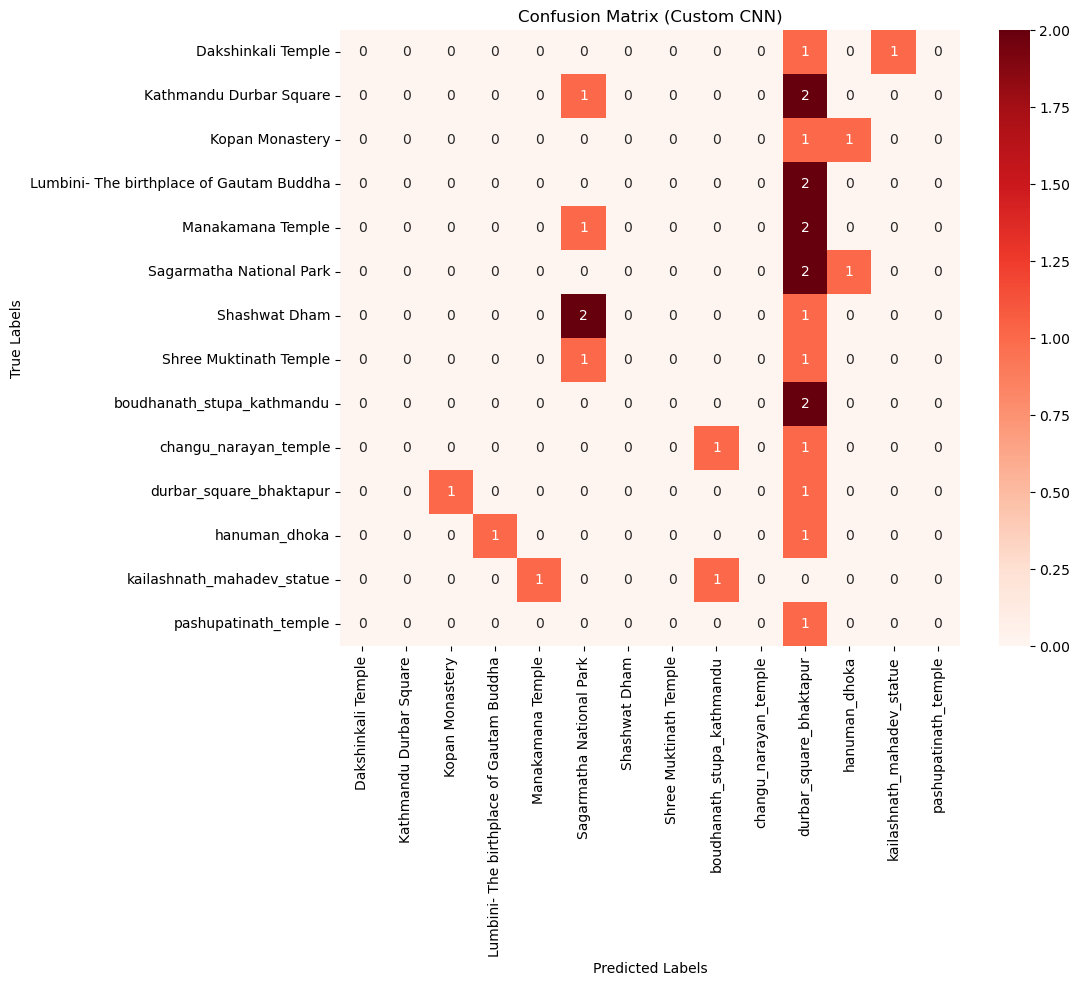

Classification Report (Custom CNN):
                                          precision    recall  f1-score   support

                      Dakshinkali Temple       0.00      0.00      0.00         2
                 Kathmandu Durbar Square       0.00      0.00      0.00         3
                         Kopan Monastery       0.00      0.00      0.00         2
Lumbini- The birthplace of Gautam Buddha       0.00      0.00      0.00         2
                       Manakamana Temple       0.00      0.00      0.00         3
                Sagarmatha National Park       0.00      0.00      0.00         3
                           Shashwat Dham       0.00      0.00      0.00         3
                  Shree Muktinath Temple       0.00      0.00      0.00         2
              boudhanath_stupa_kathmandu       0.00      0.00      0.00         2
                   changu_narayan_temple       0.00      0.00      0.00         2
                 durbar_square_bhaktapur       0.06      0.50

In [15]:
# Import required metrics and visualization libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculate confusion matrix using true and predicted labels
cm = confusion_matrix(y_true, y_pred_classes)

# Create figure with specified size
plt.figure(figsize=(10, 8))

# Plot confusion matrix as heatmap
# annot=True shows numbers in cells
# fmt='d' formats numbers as integers
# cmap='Blues' sets blue color scheme
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels, yticklabels=class_labels)

# Add title and axis labels
plt.title('Confusion Matrix (Custom CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report showing precision, recall, f1-score
# zero_division=0 handles division by zero cases
print("Classification Report (Custom CNN):")
print(classification_report(y_true, y_pred_classes, target_names=class_labels, zero_division = 0))

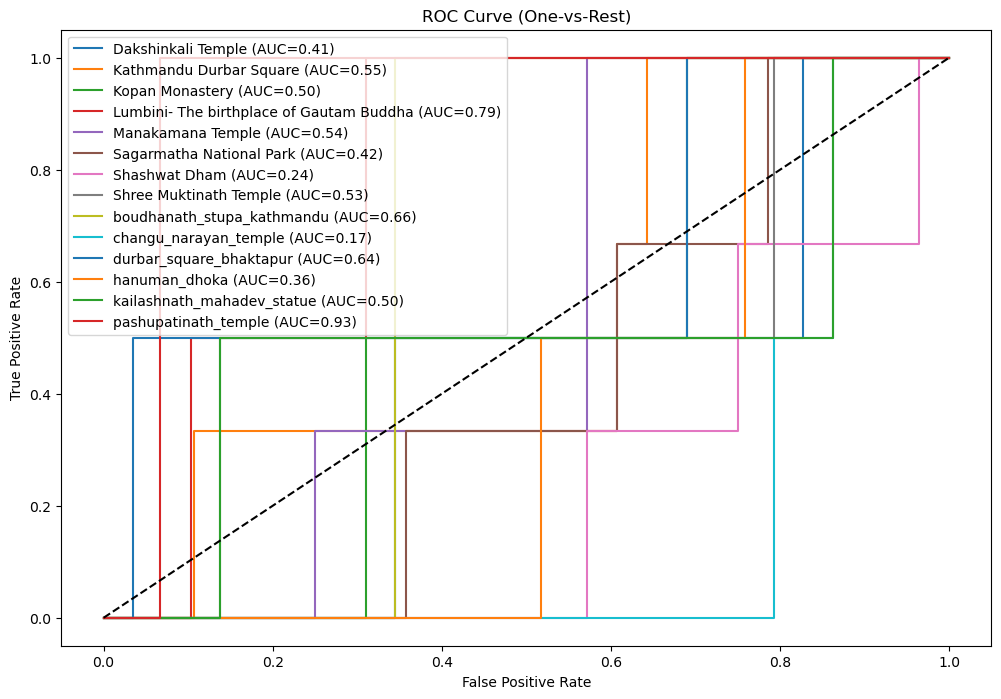

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


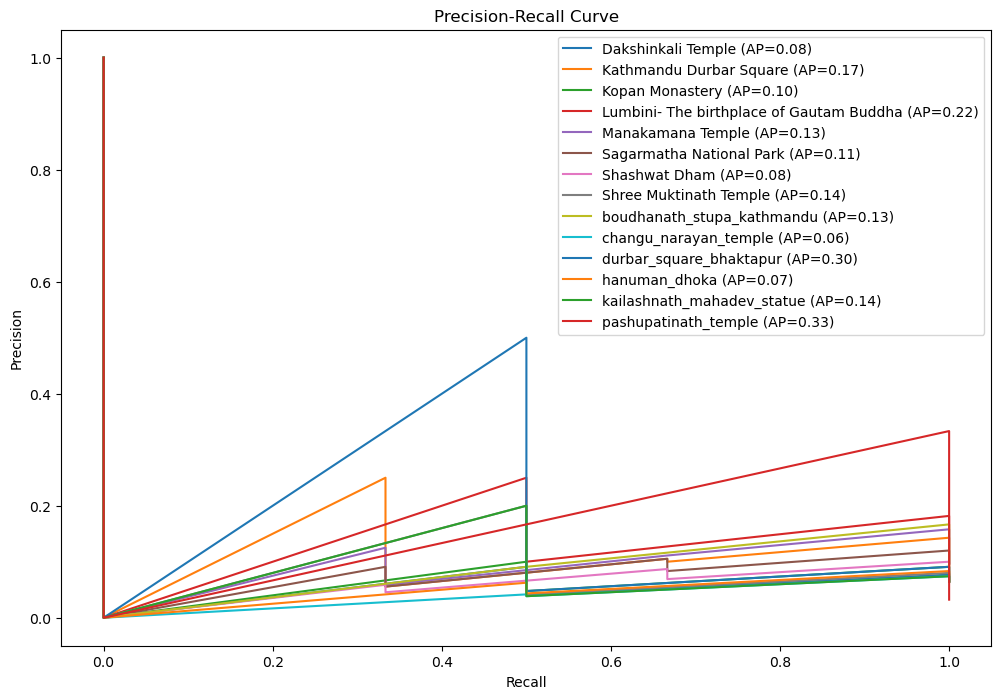

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create figure with specified size
plt.figure(figsize=(12, 8))

# Loop through each class to plot individual precision-recall curves
for i in range(num_classes):
    # Calculate precision and recall values for current class
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    
    # Calculate average precision score for current class
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    
    # Plot precision-recall curve with class label and AP score in legend
    plt.plot(recall, precision, label=f"{class_labels[i]} (AP={avg_precision:.2f})")

# Add title and axis labels
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

# Add legend to show class labels and AP scores
plt.legend()

# Display the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


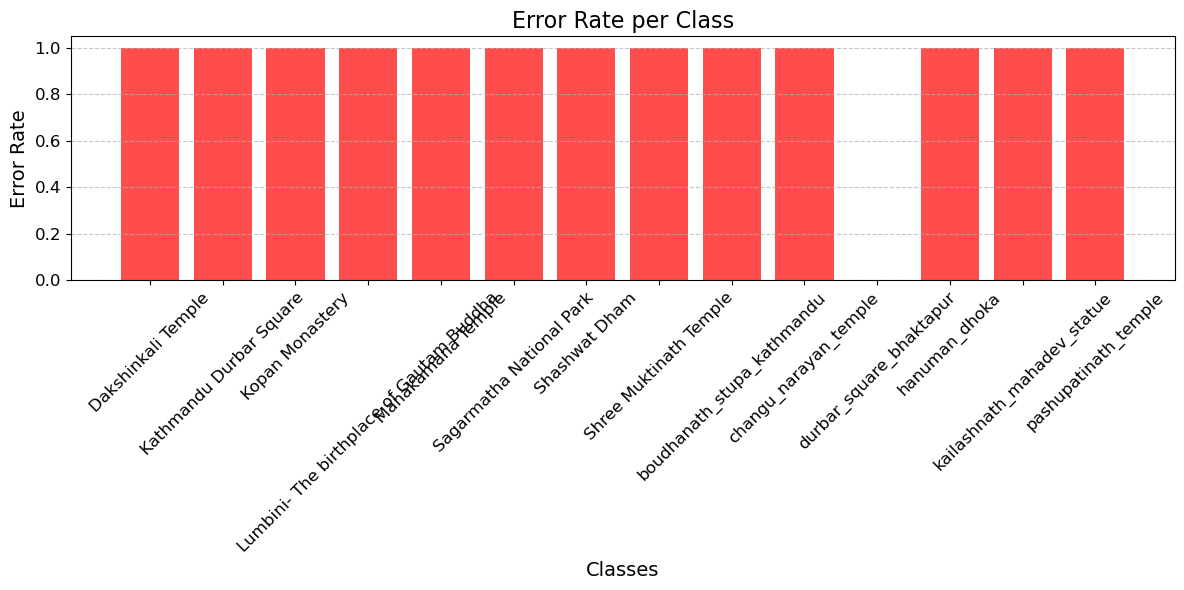

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Generate Confusion Matrix
y_true = test_data.classes  # True labels
y_pred_classes = np.argmax(model.predict(test_data), axis=1)  # Predicted labels
cm = confusion_matrix(y_true, y_pred_classes)

# Step 2: Calculate Error Rates for Each Class
class_labels = list(test_data.class_indices.keys())  # Get class labels
error_rates = []

for i in range(len(class_labels)):
    total_samples = np.sum(cm[i])  # Total samples in the true class
    true_positives = cm[i, i]      # Diagonal element (true positives)
    accuracy = true_positives / total_samples if total_samples > 0 else 0
    error_rate = 1 - accuracy      # Error rate for the class
    error_rates.append(error_rate)

# Step 3: Plot Error Rates as a Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(class_labels, error_rates, color='red', alpha=0.7)
plt.title("Error Rate per Class", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
import os

# Define custom directory
custom_dir = "C:/Users/sache/OneDrive/Desktop/Classes/dataset"

# Create directory if it doesn't exist
os.makedirs(custom_dir, exist_ok=True)

# Save the model to the custom path
model.save(os.path.join(custom_dir, "custom_cnn_model.h5"))


In [20]:
from tensorflow.keras.models import Model
def create_resnet_model(input_shape, num_classes):
    # Initialize pre-trained ResNet50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers to prevent training
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification layers on top of base model
    x = base_model.output
    x = Flatten()(x)                                    # Flatten the 2D feature maps
    x = Dense(512, activation='relu')(x)                # Add fully connected layer with ReLU
    x = Dropout(0.5)(x)                                 # Add dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax
    
    # Create and return the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [21]:
# Create and compile ResNet model with specified input shape and number of classes
resnet_model = create_resnet_model(input_shape, num_classes)
resnet_model.compile(optimizer='adam',                    # Use Adam optimizer
                     loss='categorical_crossentropy',     # Loss function for multi-class classification
                     metrics=['accuracy'])                # Track accuracy during training

# Display model architecture and parameters
print("\nResNet50 Model Summary:")
resnet_model.summary()

# Train the ResNet50 model on training data
print("\nTraining ResNet50 Model...")
history_resnet = resnet_model.fit(
    train_data,              # Training dataset
    epochs=20,              # Number of complete passes through the training data
    validation_data=test_data # Dataset used to evaluate model during training
)


ResNet50 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 40,372,622 (154.01 MB)

 Trainable params: 16,784,910 (64.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training ResNet50 Model...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.0551 - loss: 3.7811 - val_accuracy: 0.0645 - val_loss: 2.7530
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.1068 - loss: 3.0534 - val_accuracy: 0.1613 - val_loss: 2.5418
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.1433 - loss: 2.5882 - val_accuracy: 0.2581 - val_loss: 2.5042
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.1787 - loss: 2.5101 - val_accuracy: 0.1290 - val_loss: 2.5114
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1317 - loss: 2.5198 - val_accuracy: 0.3226 - val_loss: 2.4571
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1096 - loss: 2.5108 - val_accuracy: 0.0968 - val_loss: 2.4720
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.1452 - loss: 2.4884 - val_accuracy: 0.1290 - val_loss: 2.4497
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1729 - loss: 2.4629 - val_

KeyboardInterrupt: 

In [ ]:
# Import required libraries for cross validation and data processing
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

def cross_validate_model(model_fn, input_shape, num_classes, data, labels, k_folds=5):
    # Initialize K-Fold cross validator with specified number of folds and random seed
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    # Create empty list to store accuracy scores for each fold
    fold_scores = []
    
    # Loop through each fold of the data
    for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
        # Print current fold number for tracking progress
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split data into training and validation sets using fold indices
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Convert integer labels to one-hot encoded format
        y_train = to_categorical(y_train, num_classes)
        y_val = to_categorical(y_val, num_classes)
        
        # Create a new model instance for this fold
        model = model_fn(input_shape, num_classes)
        # Configure model training parameters
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model on this fold's training data
        history = model.fit(X_train, y_train,
                            epochs=10,
                            validation_data=(X_val, y_val),
                            verbose=1)
        
        # Evaluate model performance on validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        # Store the validation accuracy for this fold
        fold_scores.append(val_accuracy)
        # Print the validation accuracy for this fold
        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.2f}")
    
    # Print the average accuracy across all folds
    print(f"\nAverage Cross-Validation Accuracy: {np.mean(fold_scores):.2f}")
    # Return list of validation scores from all folds
    return fold_scores

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

# Define the cross-validation function
def cross_validate_model(model_fn, input_shape, num_classes, data, labels, k_folds=5):
    """
    Perform k-fold cross-validation on a given model.
    
    Args:
        model_fn: Function to create the model (e.g., create_cnn_model).
        input_shape: Input shape for the model.
        num_classes: Number of classes in the dataset.
        data: Numpy array of all images.
        labels: Numpy array of all class indices.
        k_folds: Number of folds for cross-validation.
    
    Returns:
        List of validation accuracies for each fold.
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split data into training and validation sets
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Convert labels to categorical (one-hot encoding)
        y_train = to_categorical(y_train, num_classes)
        y_val = to_categorical(y_val, num_classes)
        
        # Build and compile the model
        model = model_fn(input_shape, num_classes)
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train, y_train,
                            epochs=10,  # Adjust epochs as needed
                            validation_data=(X_val, y_val),
                            verbose=1)
        
        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        fold_scores.append(val_accuracy)
        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.2f}")
    
    print(f"\nAverage Cross-Validation Accuracy: {np.mean(fold_scores):.2f}")
    return fold_scores

# Prepare data for cross-validation
print("\nPreparing Data for Cross-Validation...")
all_images, all_labels = [], []

# Iterate through training data batches and collect images and labels
for images, labels in train_data:
    all_images.append(images)
    # Convert one-hot encoded labels back to class indices
    all_labels.append(np.argmax(labels, axis=1))

# Combine all batches into single numpy arrays
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

# Perform k-fold cross-validation on the custom CNN model
print("\nPerforming Cross-Validation on Custom CNN Model...")
cross_validate_model(create_cnn_model, input_shape, num_classes, all_images, all_labels)

# Define and train the ResNet50 model
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Define the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create and compile ResNet50 model
resnet_model = create_resnet_model(input_shape, num_classes)
resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the ResNet50 model
print("\nTraining ResNet50 Model...")
history_resnet = resnet_model.fit(
    train_data,
    epochs=10,  # Adjust epochs as needed
    validation_data=test_data,
    verbose=1
)

# Evaluate and compare model performance on test data
print("\nEvaluating Models on Test Data...")
# Get test metrics for custom CNN model
test_loss_custom, test_accuracy_custom = model.evaluate(test_data, verbose=0)
# Get test metrics for ResNet50 model
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_data, verbose=0)

# Print comparison of model accuracies
print("\nModel Comparison:")
print(f"Custom CNN Test Accuracy: {test_accuracy_custom:.2f}")
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet:.2f}")

In [ ]:
# Save Model Files
model.save("custom_cnn_model.h5")
resnet_model.save("resnet_model.h5")
print("\nModels saved as 'custom_cnn_model.h5' and 'resnet_model.h5'")